In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/cleaned insurance.csv')

In [ ]:
df.shape

(1337, 10)

In [ ]:
df.head()

,Unnamed: 0,age,sex,bmi,children,smoker,region,charges,age_range,bmi_range
0,0,19,female,27.900,0,yes,southwest,16884.92400,young,overweight
1,1,18,male,33.770,1,no,southeast,1725.55230,young,obese
2,2,28,male,33.000,3,no,southeast,4449.46200,young,obese
3,3,33,male,22.705,0,no,northwest,21984.47061,middle-aged,normal
4,4,32,male,28.880,0,no,northwest,3866.85520,middle-aged,overweight


**Feature Engineering**

Numerical and Categorical Features

In [ ]:
numerical_features = [feature for feature in df.columns if df[feature].dtype!='O']
categorical_features = [feature for feature in df.columns if df[feature].dtype=='O']

print(f'We have {len(numerical_features)} numerical features : {numerical_features}')
print(f'We have {len(categorical_features)} categorical features : {categorical_features}')

print("\nCategories in 'sex' variable:     ",end=" " )
print(df['sex'].unique())

print("Categories in 'smoker' variable:  ",end=" ")
print(df['smoker'].unique())

print("Categories in'region' variable:",end=" " )
print(df['region'].unique())

We have 5 numerical features : ['Unnamed: 0', 'age', 'bmi', 'children', 'charges']
We have 5 categorical features : ['sex', 'smoker', 'region', 'age_range', 'bmi_range']

Categories in 'sex' variable:      ['female' 'male']
Categories in 'smoker' variable:   ['yes' 'no']
Categories in'region' variable: ['southwest' 'southeast' 'northwest' 'northeast']


Adding columns

In [ ]:
df['age_range'] = 'old'
df.loc[(df['age'] > 0) & (df['age'] <= 30), 'age_range'] = 'young'
df.loc[(df['age'] > 30) & (df['age'] <= 60), 'age_range'] = 'middle-aged'
df.head()

,Unnamed: 0,age,sex,bmi,children,smoker,region,charges,age_range,bmi_range
0,0,19,female,27.900,0,yes,southwest,16884.92400,young,overweight
1,1,18,male,33.770,1,no,southeast,1725.55230,young,obese
2,2,28,male,33.000,3,no,southeast,4449.46200,young,obese
3,3,33,male,22.705,0,no,northwest,21984.47061,middle-aged,normal
4,4,32,male,28.880,0,no,northwest,3866.85520,middle-aged,overweight


In [ ]:
df['bmi_range'] = 'normal'
df.loc[(df['bmi'] < 18.5), 'bmi_range'] = 'underweight'
df.loc[(df['bmi'] > 25.0) & (df['bmi'] < 29.9), 'bmi_range'] = 'overweight'
df.loc[(df['bmi'] > 30.0), 'bmi_range'] = 'obese'
df.head()

,Unnamed: 0,age,sex,bmi,children,smoker,region,charges,age_range,bmi_range
0,0,19,female,27.900,0,yes,southwest,16884.92400,young,overweight
1,1,18,male,33.770,1,no,southeast,1725.55230,young,obese
2,2,28,male,33.000,3,no,southeast,4449.46200,young,obese
3,3,33,male,22.705,0,no,northwest,21984.47061,middle-aged,normal
4,4,32,male,28.880,0,no,northwest,3866.85520,middle-aged,overweight


**Modeling**

In [ ]:
# Excluding age_range and bmi_range
X1 = df.drop(columns=['age_range', 'bmi_range', 'charges'], axis=1)
y = df['charges']

# Excluding age and bmi
X2 = df.drop(columns=['age', 'bmi', 'charges'], axis=1)

In [ ]:
# Data Preprocessing
num_features = X2.select_dtypes(exclude='object').columns
cat_features = X2.select_dtypes(include='object').columns

scaler = StandardScaler()
oh_encoder = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder',oh_encoder,cat_features),
        ('StandardScaler',scaler,num_features)
    ]
)

In [ ]:
print(num_features)
print(cat_features)

Index(['Unnamed: 0', 'children'], dtype='object')
Index(['sex', 'smoker', 'region', 'age_range', 'bmi_range'], dtype='object')


In [ ]:
X2 = preprocessor.fit_transform(X2)
X2

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
        -1.73031248, -0.90923416],
       [ 0.        ,  1.        ,  1.        , ...,  0.        ,
        -1.72772438, -0.07944162],
       [ 0.        ,  1.        ,  1.        , ...,  0.        ,
        -1.72513628,  1.58014347],
       ...,
       [ 1.        ,  0.        ,  1.        , ...,  0.        ,
         1.72479753, -0.90923416],
       [ 1.        ,  0.        ,  1.        , ...,  0.        ,
         1.72738562, -0.90923416],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.72997372, -0.90923416]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1069, 17), (268, 17))

In [ ]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    r2 = r2_score(true, predicted)
    rmse = np.sqrt(mse)
    return mae, mse, r2, rmse

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]

    # Training
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluations
    model_train_mae, model_train_mse, model_train_r2, model_train_rmse = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_mse, model_test_r2, model_test_rmse = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 6409.1417
- Mean Absolute Error: 4578.1649
- R2 Score: 0.7000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6370.7256
- Mean Absolute Error: 4662.7047
- R2 Score: 0.7791


Lasso
Model performance for Training set
- Root Mean Squared Error: 6346.7242
- Mean Absolute Error: 4619.8920
- R2 Score: 0.7058
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6481.8441
- Mean Absolute Error: 4802.0753
- R2 Score: 0.7714


Ridge
Model performance for Training set
- Root Mean Squared Error: 6346.8830
- Mean Absolute Error: 4620.2794
- R2 Score: 0.7058
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6482.9416
- Mean Absolute Error: 4802.1503
- R2 Score: 0.7713


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5272.4005
- Mean Absolute Error: 3571.7343


In [ ]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2 Score']).sort_values(by=['R2 Score'], ascending=False)

,Model Name,R2 Score
7,CatBoosting Regressor,0.866507
5,Random Forest Regressor,0.857530
8,AdaBoost Regressor,0.852824
6,XGBRegressor,0.831051
0,Linear Regression,0.779130
1,Lasso,0.771358
2,Ridge,0.771281
3,K-Neighbors Regressor,0.753244
4,Decision Tree,0.720840


In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
score = r2_score(y_test, y_pred) * 100

print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 85.50


Text(0, 0.5, 'Predicted')

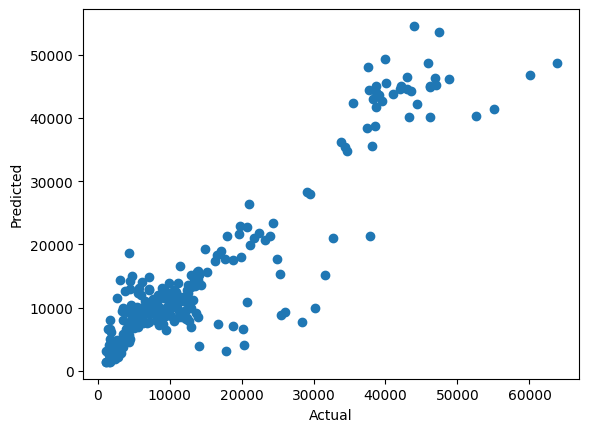

In [ ]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

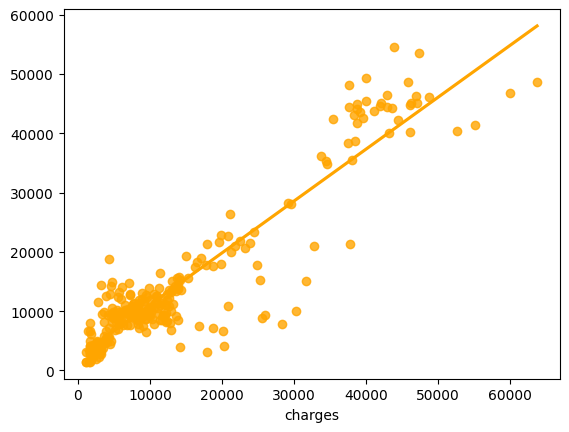

In [ ]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='orange');

In [ ]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
899,8688.85885,10030.669118,-1341.810268
1063,5708.86700,9246.527224,-3537.660224
1255,11436.73815,16519.342658,-5082.604508
298,38746.35510,45007.422206,-6261.067106
237,4463.20510,12959.148988,-8495.943888
...,...,...,...
534,13831.11520,13852.093135,-20.977935
542,13887.20400,14455.021839,-567.817839
759,3925.75820,6631.034636,-2705.276436
1283,47403.88000,53634.665464,-6230.785464
